# Задание 1

In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)
n = 100
seasonality = np.sin(np.linspace(0, 2*np.pi, n))  # синусоида для сезонности
weather = np.random.normal(0, 1, n)               # погодные условия
price = np.random.uniform(10, 50, n)              # цены

# истинные параметры
beta_0, beta_1, beta_2, beta_3 = 100, -1.5, 20, 5
sigma_true = 10

demand = (beta_0 + beta_1 * price + beta_2 * seasonality +
          beta_3 * weather + np.random.normal(0, sigma_true, n))

data = pd.DataFrame({'demand': demand, 'price': price,
                     'seasonality': seasonality, 'weather': weather})


In [2]:
# априоры: нормальные для коэффициентов, инверс-гамма для дисперсии
mu_prior = 0
sigma_prior = 100
alpha_prior = 2
beta_prior = 2

# инициализация параметров
beta = np.zeros(4)
sigma2 = 1.0


In [3]:
n_iter = 5000
samples = np.zeros((n_iter, 5))  # 4 beta + sigma^

X = np.column_stack((np.ones(n), price, seasonality, weather))
y = demand

for i in range(n_iter):
    for j in range(4):
        X_j = X[:, j]
        X_not_j = np.delete(X, j, axis=1)
        beta_not_j = np.delete(beta, j)
        y_resid = y - X_not_j @ beta_not_j
        var_j = 1 / (np.sum(X_j**2) / sigma2 + 1 / sigma_prior**2)
        mean_j = var_j * (np.sum(X_j * y_resid) / sigma2 + mu_prior / sigma_prior**2)
        beta[j] = np.random.normal(mean_j, np.sqrt(var_j))
    
    y_pred = X @ beta
    alpha_post = alpha_prior + n / 2
    beta_post = beta_prior + 0.5 * np.sum((y - y_pred) ** 2)
    sigma2 = 1 / np.random.gamma(alpha_post, 1 / beta_post)
    samples[i, :-1] = beta
    samples[i, -1] = sigma2


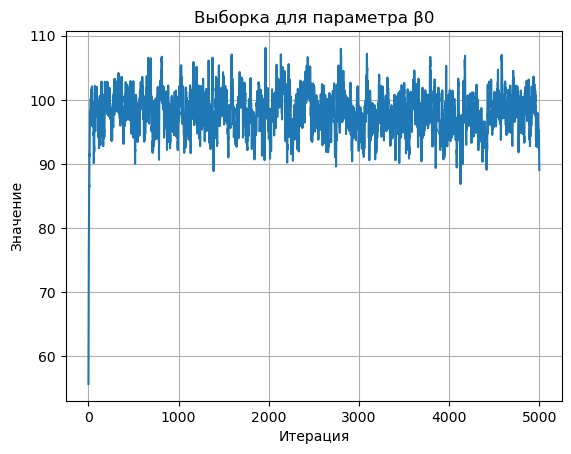

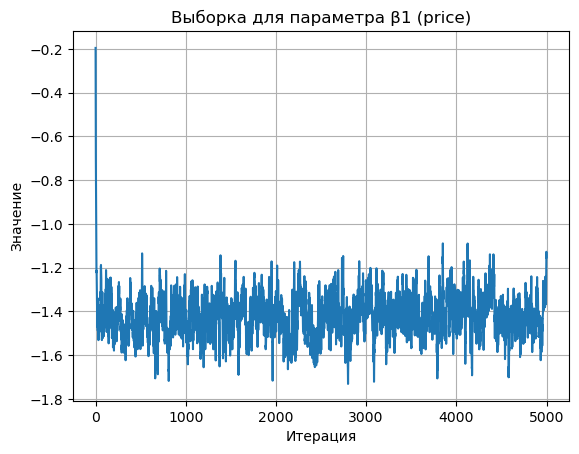

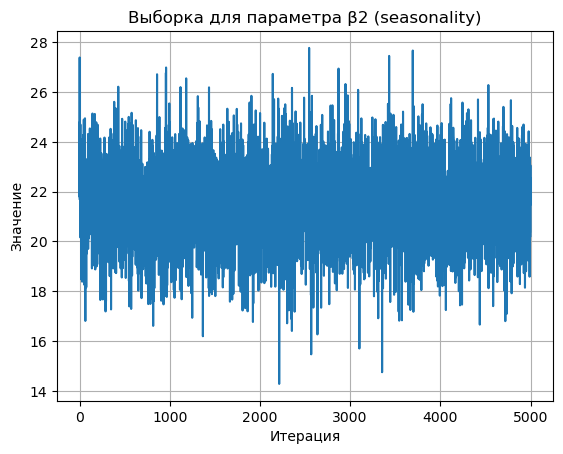

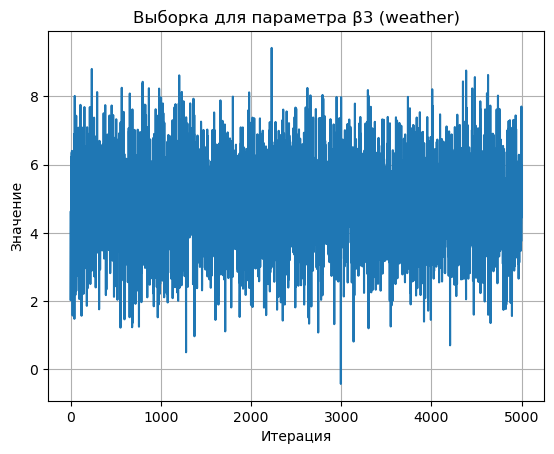

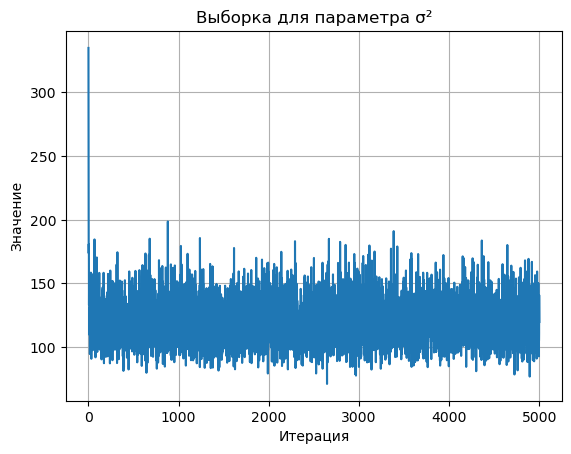

In [4]:
import matplotlib.pyplot as plt

param_names = ['β0', 'β1 (price)', 'β2 (seasonality)', 'β3 (weather)', 'σ²']
for i in range(5):
    plt.figure()
    plt.plot(samples[:, i])
    plt.title(f'Выборка для параметра {param_names[i]}')
    plt.xlabel('Итерация')
    plt.ylabel('Значение')
    plt.grid()
    plt.show()


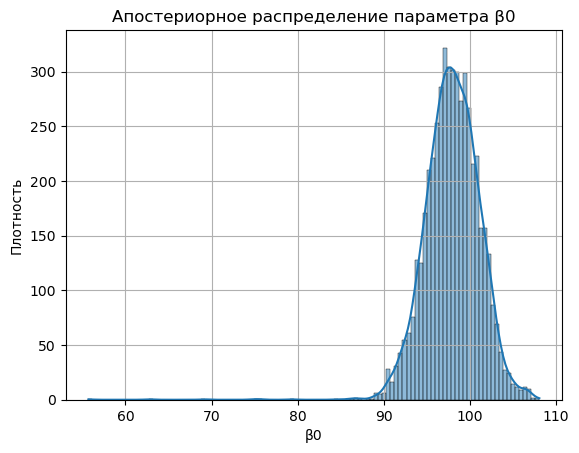

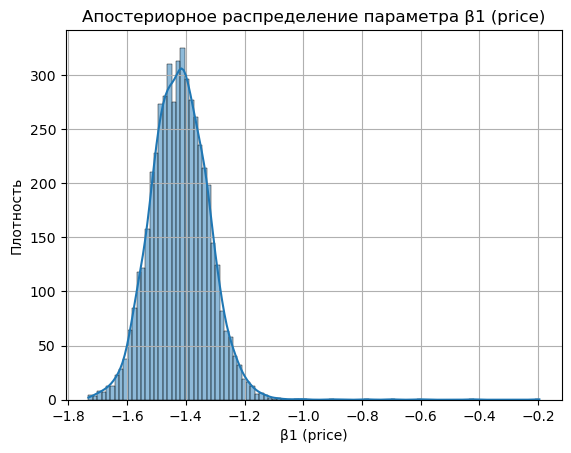

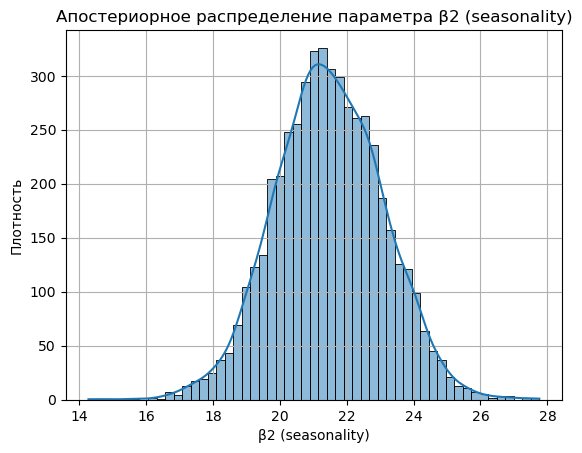

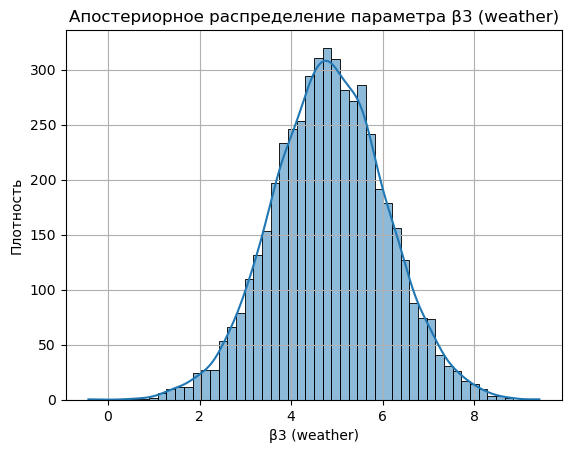

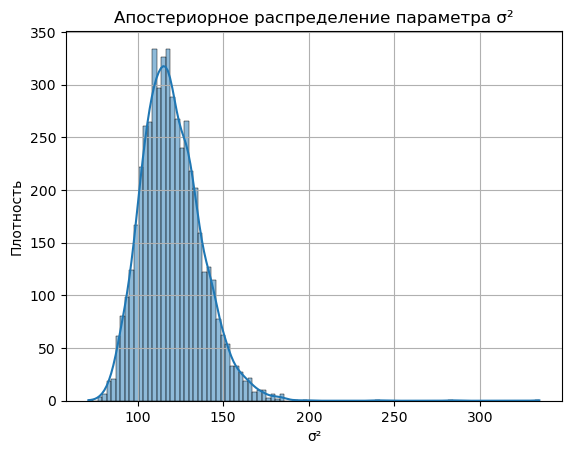

In [5]:
import seaborn as sns


for i in range(5):
    plt.figure()
    sns.histplot(samples[:, i], kde=True)
    plt.title(f"Апостериорное распределение параметра {param_names[i]}")
    plt.xlabel(param_names[i])
    plt.ylabel("Плотность")
    plt.grid()
    plt.show()


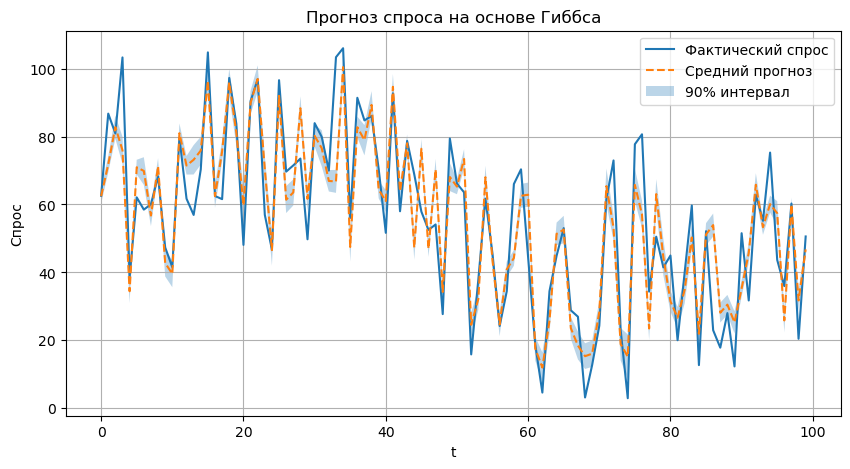

In [6]:
#Прогноз
X_new = X 
y_preds = X_new @ samples[:, :4].T 
y_mean = np.mean(y_preds, axis=1)

plt.figure(figsize=(10, 5))
plt.plot(y, label='Фактический спрос')
plt.plot(y_mean, label='Средний прогноз', linestyle='--')
plt.fill_between(range(n),
                 np.percentile(y_preds, 5, axis=1),
                 np.percentile(y_preds, 95, axis=1),
                 alpha=0.3, label='90% интервал')

plt.title('Прогноз спроса на основе Гиббса')
plt.xlabel('t')
plt.ylabel('Спрос')
plt.legend()
plt.grid()
plt.show()


# Задание 2

In [10]:
np.random.seed(42)
N = 500  # количество наблюдений
noise_sigma = 10  # стандартное отклонение шума
true_weights = np.array([100, 2.5, 10, 1.2, 0.8, 5.0, 3.0, -1.5, 15.0])  # w0 ... w8

In [11]:
def generate_data(n):
    demand = np.random.uniform(0, 100, n)
    weather = np.random.randint(0, 3, n)
    hour = np.random.randint(0, 24, n)
    day = np.random.randint(1, 8, n)
    distance = np.random.uniform(1, 50, n)
    traffic = np.random.uniform(0, 10, n)
    competition = np.random.uniform(0, 50, n)
    season = np.random.randint(0, 2, n)

    X = np.column_stack([
        np.ones(n), demand, weather, hour, day,
        distance, traffic, competition, season
    ])

    y = X @ true_weights + np.random.normal(0, noise_sigma, n)
    return X, y

X, y = generate_data(N)

In [12]:
def metropolis_hastings(X, y, n_iter=5000, proposal_std=0.5):
    n_params = X.shape[1]
    samples = np.zeros((n_iter, n_params))
    w = np.zeros(n_params)
    sigma2 = noise_sigma ** 2
    prior_var = 100

    def log_posterior(w):
        residuals = y - X @ w
        log_likelihood = -0.5 * np.sum(residuals**2) / sigma2
        log_prior = -0.5 * np.sum(w**2) / prior_var
        return log_likelihood + log_prior

    accepted = 0
    for i in range(n_iter):
        w_new = w + np.random.normal(0, proposal_std, n_params)
        log_alpha = log_posterior(w_new) - log_posterior(w)
        if np.log(np.random.rand()) < log_alpha:
            w = w_new
            accepted += 1
        samples[i] = w
    return samples

mh_samples = metropolis_hastings(X, y)

In [13]:
def gibbs_sampler(X, y, n_iter=5000):
    n, d = X.shape
    sigma2 = noise_sigma ** 2
    tau2 = 100  # априорное
    samples = np.zeros((n_iter, d))

    XtX = X.T @ X
    XtY = X.T @ y
    Sigma_inv = XtX + (1 / tau2) * np.eye(d)
    Sigma = np.linalg.inv(Sigma_inv)
    mu = Sigma @ XtY

    for i in range(n_iter):
        w = np.random.multivariate_normal(mu, sigma2 * Sigma)
        samples[i] = w
    return samples

gibbs_samples = gibbs_sampler(X, y)

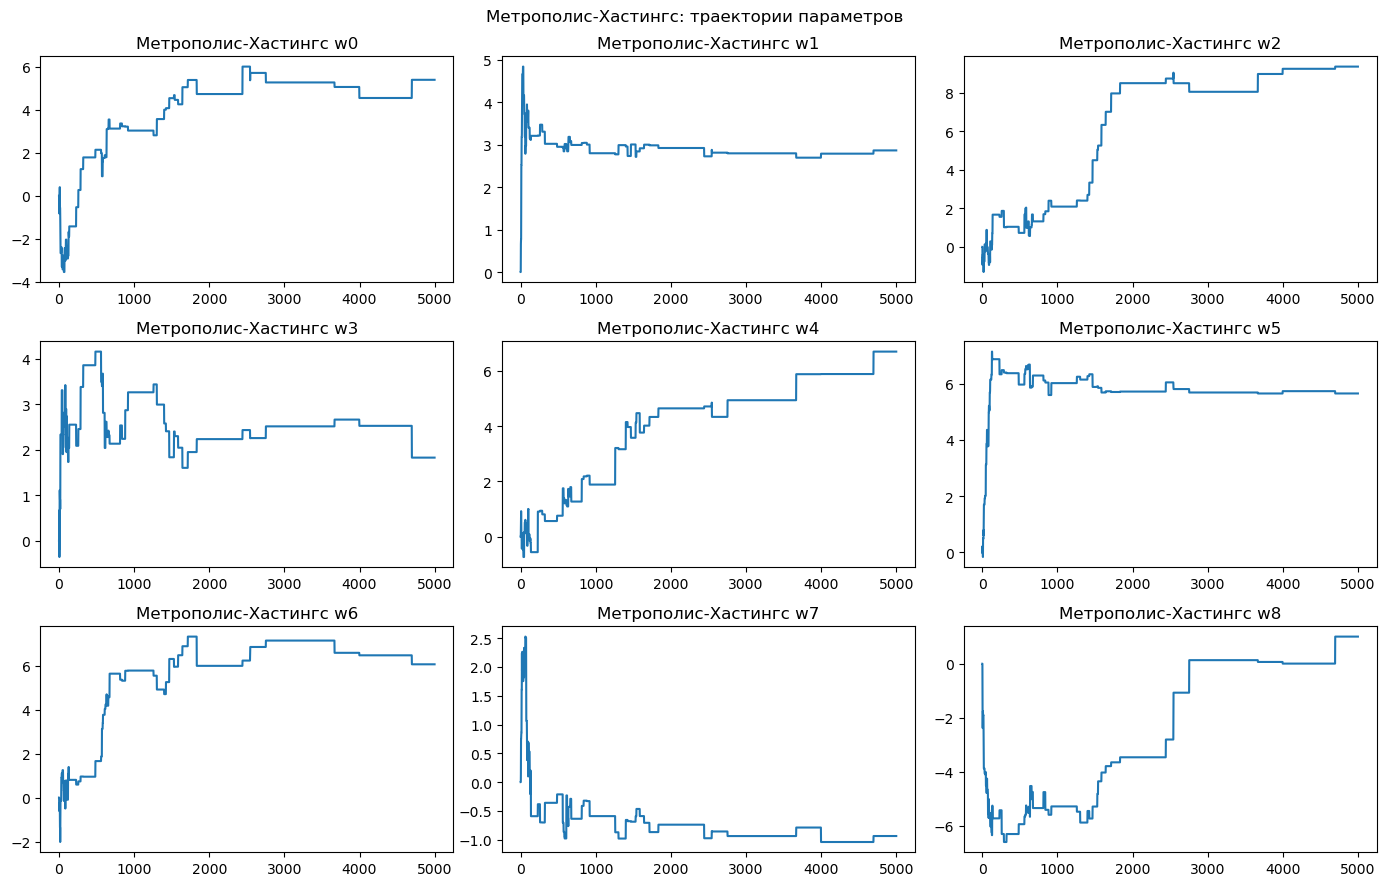

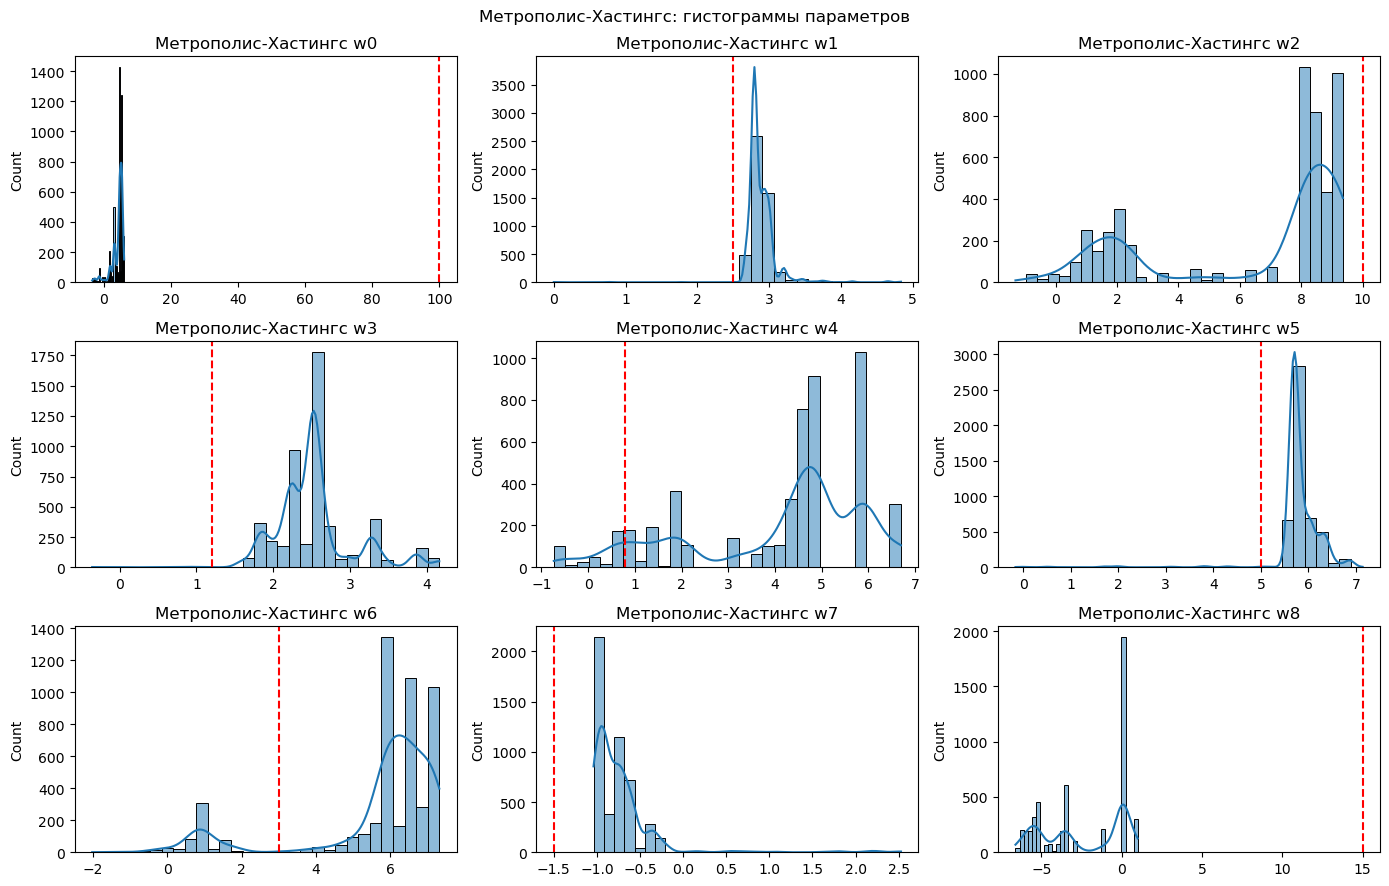

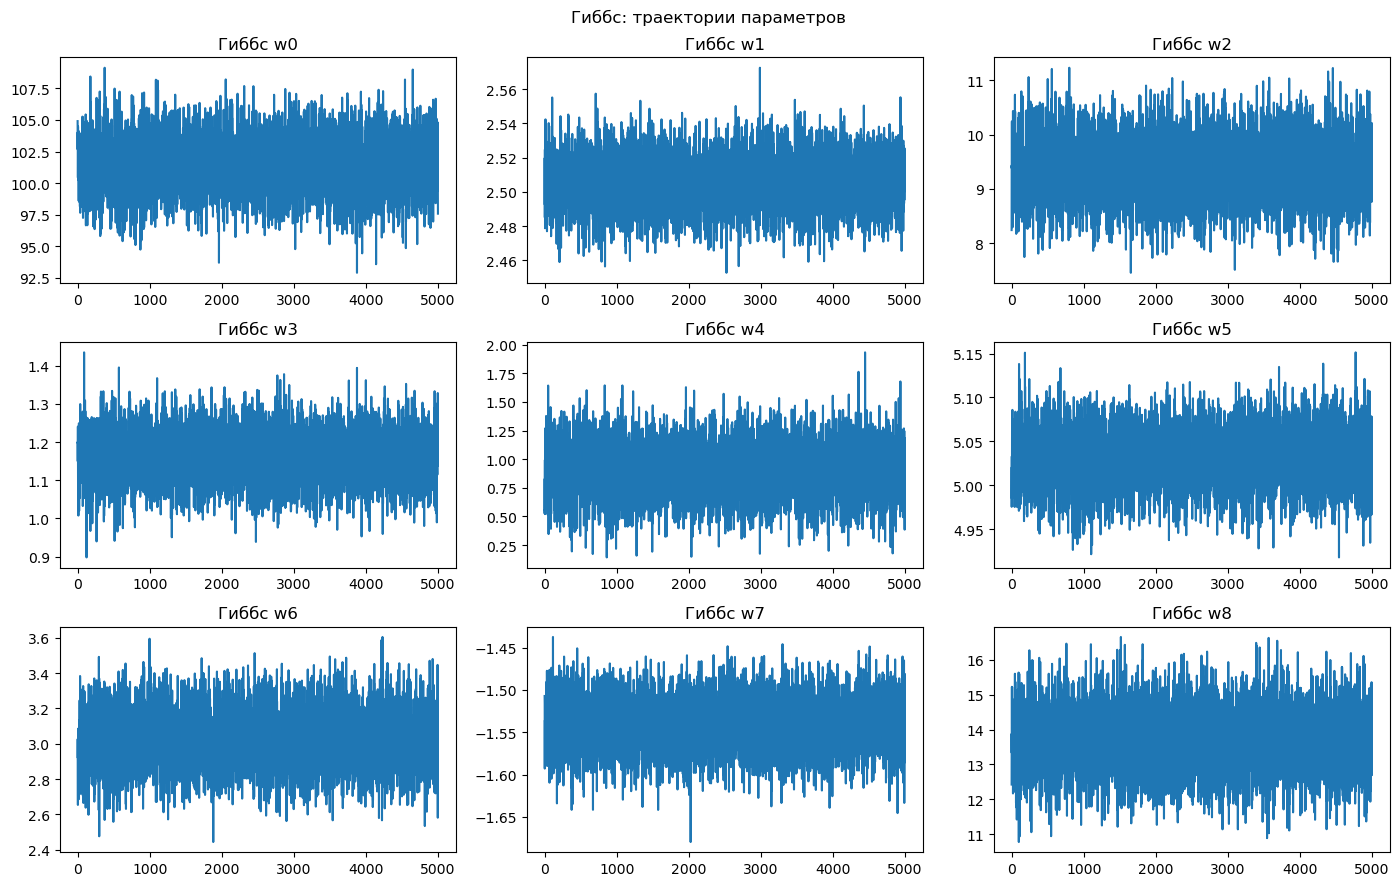

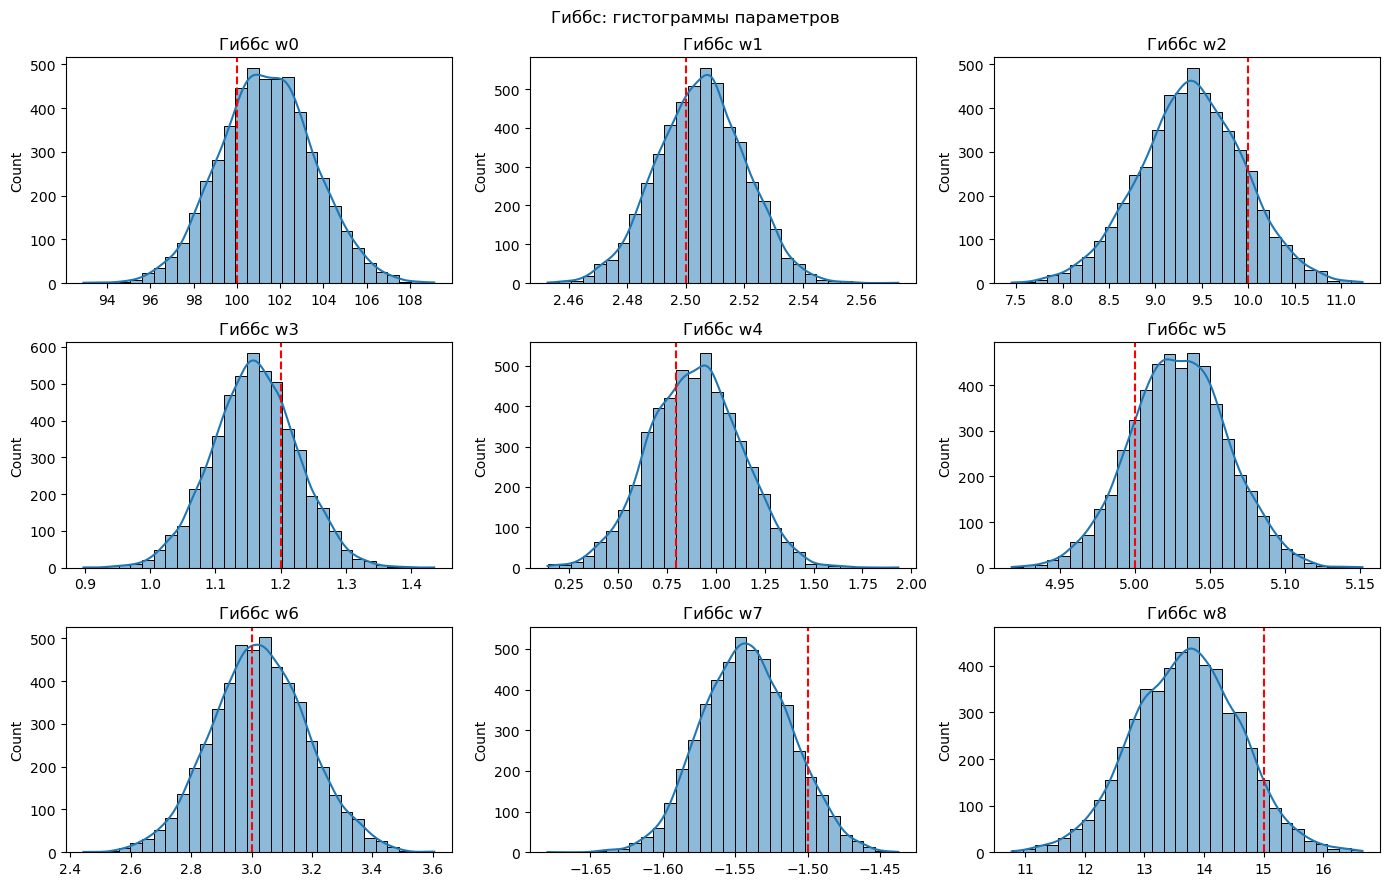

In [14]:
def plot_traces(samples, name):
    fig, axes = plt.subplots(3, 3, figsize=(14, 9))
    for i, ax in enumerate(axes.flat):
        ax.plot(samples[:, i])
        ax.set_title(f'{name} w{i}')
    fig.suptitle(f'{name}: траектории параметров')
    plt.tight_layout()
    plt.show()

def plot_histograms(samples, name):
    fig, axes = plt.subplots(3, 3, figsize=(14, 9))
    for i, ax in enumerate(axes.flat):
        sns.histplot(samples[:, i], bins=30, kde=True, ax=ax)
        ax.set_title(f'{name} w{i}')
        ax.axvline(true_weights[i], color='r', linestyle='--')
    fig.suptitle(f'{name}: гистограммы параметров')
    plt.tight_layout()
    plt.show()

plot_traces(mh_samples, "Метрополис-Хастингс")
plot_histograms(mh_samples, "Метрополис-Хастингс")

plot_traces(gibbs_samples, "Гиббс")
plot_histograms(gibbs_samples, "Гиббс")

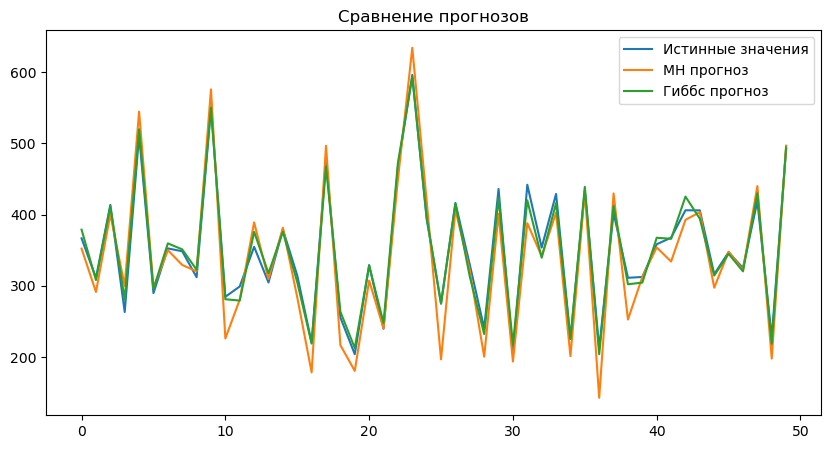

In [15]:
X_test, y_test = generate_data(50)

def predict_posterior(samples, X_test):
    preds = X_test @ samples.T
    mean_preds = preds.mean(axis=1)
    return mean_preds, preds

mean_mh, all_mh = predict_posterior(mh_samples[::10], X_test)
mean_gibbs, all_gibbs = predict_posterior(gibbs_samples[::10], X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Истинные значения')
plt.plot(mean_mh, label='MH прогноз')
plt.plot(mean_gibbs, label='Гиббс прогноз')
plt.title("Сравнение прогнозов")
plt.legend()
plt.show()

1. Как отличаются результаты алгоритма Гиббса и Метрополиса-Хастингса на задаче динамического ценообразования?
Гиббс-семплирование даёт более стабильные и точные оценки, когда можно аналитически выразить условные распределения (как в линейной модели с нормальным шумом).
Метрополис-Хастингс (MH) — более универсален, но часто: Медленнее сходится, Чувствителен к шагу предложения (proposal_std), Может застревать в "локальных" частях апостериора
2. Какие из алгоритмов эффективнее с точки зрения времени сходимости? В данной задаче Гиббс предпочтительнее, так как: линейная модель, нормальный шум, есть аналитическое решение для распределения параметров
3. Как улучшить производительность МЦМК-алгоритмов?
Использовать диагональные ковариационные матрицы в Гиббсе, Использовать регуляризацию через априорное распределение